In [2]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import sys, os
import copy
import seaborn as sns
from copy import deepcopy
import scipy.stats

# Summary 
## Experimental Design

This in the analysis of the data gathered by the Stimulus pre-test.
The general structure of the experiment was as follows:
Participants were presented with lists of stimuli pairs and had to learn which pairs are classified as "valid" and which as "invalid". 
It includes 1 baseline and 3 experimental conditions.

In the "baseline" condition, participants had to learn to classify 6 pairs of 4-letter non-words.

In the "visual" condition, participants had to learn to classify 6 pairs of shapes and 4-letter non-words.

In the "distractor" condition, participants had to learn to classify 6 pairs of 4-letter non-words, for which the invaid 
pairs were novel combinations of the words forming the valid pairs (as opposed to one word from the valid pair pool and one completely new one).

In the "Setsize" condition, participants had to learn to classify 10 pairs of shapes and 4-letter non-words.

In each condition, half of the stimuli pairs were "valid" and the other half "invalid". 

## Results 

With data gathered from 57 participants, the follwoing was found: 
1. No significant differences in accuracy (% of Correct Responses) between the Baseline and any of the Experimental Conditions
2. Significant difference in accuracy between valid and invalid stimulus pair --> participants show a preference for repsonding "valid"
3. Significant difference in accuracy between second trial (after receiving the first feed-back) and 5th trial only in the visual condition. 
4. Inspecting accuracy development for each participants show that most of the participants that do manage to learn the list do that early on (often in the first trial after feedback). 


## Discussion 

1. Interventions trying to manipulate difficulty were unsuccesful
2. Overall performance lower that inspected, ceiling effect for a small sub-group
3. Participants preference for responding with valid is in line with other empirical findings, namely "agreement bias". 
   Mostly described in the context of surveys, but this paper "Correct acceptance weighs more than correct rejection: a decision bias induced by question framing" explores it for prediction. 
   
  
## Conclusion 

We could exploit the general tendency to respond with "valid" rather than "inavlid" for the pilot study.
If game A presents more valid pairs than game B, than the average participant would receive more reward from game A if the reward is performance based. 

It would be easy to adapt the Stimuli pretest to test different valid-invalid ratios. 





# Prepare Data
## Read In 

In [3]:
path = "ExpData_v2.json"
data = json.load(open(path))

df_index = ["Participant", "Condition", "TrialId", "Trial_Type","Trialtime","Key", "ResponseTime",  "Correct_Response", "Block","Associated", "Stimulus_ID", "RT"]
df_data = []


N_TEST_TRIALS = 0
complete_responses = 0

for participant_index, participant_data in enumerate(data["values"]):
    
    response_data = participant_data[-1]
    if response_data != None:
        response = json.loads(response_data)
        #print(response)
        condition = response["condition"]
        participant = response["workerId"]
        timestamp = participant_data[11]
        data = response["data"]
        #checker.append(data)
        participant_responses = []
        if len(data) > 0:
            for trial in data:
                trial_id = trial["current_trial"]
                trial_data = trial["trialdata"]
                trial_time = trial['dateTime']
                trial_type = trial_data["trial_type"]
                ## attention check trials ##
                if trial_data["trial_type"] == "html-keyboard-response" and "correct" in trial_data.keys():
                    key = trial_data["key_press"]
                    time = trial_data["time_elapsed"]
                    correct = trial_data["correct"]
                    block = trial_data["block_type"]
                    
                    participant_responses.append([participant, condition, trial_id,trial_type,trial_time, key, time, correct, block])
                    
                ## instruction / break trials ##
                elif trial_data["trial_type"] == "html-keyboard-response":
                    key = trial_data["key_press"]
                    time = trial_data["time_elapsed"]
                    participant_responses.append([participant, condition, trial_id,trial_type,trial_time, key, time])
                    
                ## learning trials ## 
                elif trial_data["trial_type"] == "categorize-html":
                    
                    key = trial_data["key_press"]
                    time = trial_data["time_elapsed"]
                    associated = trial_data["associated_pair"]
                    correct = trial_data["correct"]
                    block = trial_data["block_type"]
                    stimulus_id = trial_data["stimulus_id"]
                    rt = trial_data["rt"]
                    participant_responses.append([participant, condition, trial_id,trial_type, trial_time,key, time, correct, block, associated, stimulus_id,rt])
                else:
                    print(trial_data["trial_type"])
        if len(participant_responses) > N_TEST_TRIALS and participant != "debug1Wqw5" :
            complete_responses += 1
            for d in participant_responses:
                df_data.append(d)

print("Complete responses", complete_responses)
df = pd.DataFrame(df_data, columns=df_index)
df["Trialtime"] = df["Trialtime"].astype("datetime64[ms]")
df.head()

Complete responses 60


,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT
0,6116780c007c18e89acd7281,1,0,html-keyboard-response,2021-08-16 09:16:44.695,13.0,2348,None,None,None,None,NaN
1,6116780c007c18e89acd7281,1,1,html-keyboard-response,2021-08-16 09:17:39.845,70.0,57499,None,None,None,None,NaN
2,6116780c007c18e89acd7281,1,2,html-keyboard-response,2021-08-16 09:17:52.273,70.0,69927,None,None,None,None,NaN
3,6116780c007c18e89acd7281,1,3,categorize-html,2021-08-16 09:17:56.196,74.0,73850,False,Baseline,True,base1,1915.0
4,6116780c007c18e89acd7281,1,4,categorize-html,2021-08-16 09:17:59.558,74.0,77212,False,Baseline,True,base0,1055.0


In [4]:
x = df[df["Block"]=="AttentionCheck"]
x = x[x["Correct_Response"]== False]
y = x.groupby("Participant").size()
print(y)
attention_filter = y[y>1]
print(attention_filter)

mask = df["Participant"].isin(attention_filter.index)
print(mask)
df = df[~mask]
len(df["Participant"].unique())
df.head()

Participant
599a9be505a0e30001f2001c    1
5c9102879b3d790017dbad56    1
5d543e2c68ec7c0001682a58    1
610139a0e4c7759d4cdbe03e    1
61112e9595430c179ed83520    2
61128b3773eee37c8ee87615    1
61130aa6625c523beb237643    1
6113d17fcf4f0cdf9c44b0c1    1
6115a15c77fe590a86f5c72b    1
6116780c007c18e89acd7281    1
61168a300801c7280f4a4b6e    1
6116f7d468a5db3c416d5f00    2
dtype: int64
Participant
61112e9595430c179ed83520    2
6116f7d468a5db3c416d5f00    2
dtype: int64
0       False
1       False
2       False
3       False
4       False
        ...  
4815    False
4816    False
4817    False
4818    False
4819    False
Name: Participant, Length: 4820, dtype: bool


,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT
0,6116780c007c18e89acd7281,1,0,html-keyboard-response,2021-08-16 09:16:44.695,13.0,2348,None,None,None,None,NaN
1,6116780c007c18e89acd7281,1,1,html-keyboard-response,2021-08-16 09:17:39.845,70.0,57499,None,None,None,None,NaN
2,6116780c007c18e89acd7281,1,2,html-keyboard-response,2021-08-16 09:17:52.273,70.0,69927,None,None,None,None,NaN
3,6116780c007c18e89acd7281,1,3,categorize-html,2021-08-16 09:17:56.196,74.0,73850,False,Baseline,True,base1,1915.0
4,6116780c007c18e89acd7281,1,4,categorize-html,2021-08-16 09:17:59.558,74.0,77212,False,Baseline,True,base0,1055.0


In [5]:
df["Stimulus_ID"].unique()

array([None, 'base1', 'base0', 'base3', 'base2', 'sim4', 'sim7', 'sim5',
       'sim1', 'sim3', 'sim6', 'sim2', 'sim0', 'set1', 'set9', 'set15',
       'set8', 'set13', 'set11', 'set2', 'set10', 'set5', 'set7', 'set12',
       'set0', 'set14', 'set3', 'set6', 'set4', 'double6', 'double5',
       'double4', 'double2', 'double0', 'double3', 'double1', 'double7'],
      dtype=object)

In [6]:
f_participants = ['611a160b6ca490d37eb34011','611968f5cef3c1cee6e49d14','599a9be505a0e30001f2001c']
for row in df.index:
    if df.loc[row, "Block"] == "Baseline":
        if df["Stimulus_ID"][row].startswith("base"):
            continue
        elif df["Stimulus_ID"][row].startswith("set"):
            df.loc[row, "Block"] = "Setsize"
        elif df["Stimulus_ID"][row].startswith("sim"):
            df.loc[row, "Block"] = "Similarity"
        elif df["Stimulus_ID"][row].startswith("double"):
            df.loc[row, "Block"] = "Double"
            
df.head()

,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT
0,6116780c007c18e89acd7281,1,0,html-keyboard-response,2021-08-16 09:16:44.695,13.0,2348,None,None,None,None,NaN
1,6116780c007c18e89acd7281,1,1,html-keyboard-response,2021-08-16 09:17:39.845,70.0,57499,None,None,None,None,NaN
2,6116780c007c18e89acd7281,1,2,html-keyboard-response,2021-08-16 09:17:52.273,70.0,69927,None,None,None,None,NaN
3,6116780c007c18e89acd7281,1,3,categorize-html,2021-08-16 09:17:56.196,74.0,73850,False,Baseline,True,base1,1915.0
4,6116780c007c18e89acd7281,1,4,categorize-html,2021-08-16 09:17:59.558,74.0,77212,False,Baseline,True,base0,1055.0


## Filter by Attention Check Trials

In [7]:
x = df[df["Block"]=="AttentionCheck"]
x = x[x["Correct_Response"]== False]
x

,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT
50,6116780c007c18e89acd7281,1,50,html-keyboard-response,2021-08-16 09:20:32.433,74.0,230085,False,AttentionCheck,None,None,NaN
366,599a9be505a0e30001f2001c,0,58,html-keyboard-response,2021-08-16 08:46:46.297,74.0,304965,False,AttentionCheck,None,None,NaN
540,61130aa6625c523beb237643,2,98,html-keyboard-response,2021-08-16 09:25:41.397,70.0,543066,False,AttentionCheck,None,None,NaN
955,6115a15c77fe590a86f5c72b,1,58,html-keyboard-response,2021-08-16 09:22:22.044,74.0,241027,False,AttentionCheck,None,None,NaN
1544,5d543e2c68ec7c0001682a58,1,58,html-keyboard-response,2021-08-16 09:23:05.698,74.0,282038,False,AttentionCheck,None,None,NaN
2200,6113d17fcf4f0cdf9c44b0c1,1,58,html-keyboard-response,2021-08-16 09:22:43.675,74.0,253601,False,AttentionCheck,None,None,NaN
2259,610139a0e4c7759d4cdbe03e,0,50,html-keyboard-response,2021-08-16 09:22:32.516,70.0,256783,False,AttentionCheck,None,None,NaN
3231,61128b3773eee37c8ee87615,2,98,html-keyboard-response,2021-08-16 09:32:19.834,74.0,610510,False,AttentionCheck,None,None,NaN
3499,5c9102879b3d790017dbad56,1,58,html-keyboard-response,2021-08-16 09:26:27.498,74.0,238304,False,AttentionCheck,None,None,NaN
4174,61168a300801c7280f4a4b6e,1,50,html-keyboard-response,2021-08-16 09:29:41.300,70.0,275139,False,AttentionCheck,None,None,NaN


In [8]:

attention_filter =  x["Participant"].unique()
attention_filter = ["61112e9595430c179ed83520" ]
#attention_filter
mask = df["Participant"].isin(attention_filter)
df = df[~mask]
df.head()

#61112e9595430c179ed83520

,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT
0,6116780c007c18e89acd7281,1,0,html-keyboard-response,2021-08-16 09:16:44.695,13.0,2348,None,None,None,None,NaN
1,6116780c007c18e89acd7281,1,1,html-keyboard-response,2021-08-16 09:17:39.845,70.0,57499,None,None,None,None,NaN
2,6116780c007c18e89acd7281,1,2,html-keyboard-response,2021-08-16 09:17:52.273,70.0,69927,None,None,None,None,NaN
3,6116780c007c18e89acd7281,1,3,categorize-html,2021-08-16 09:17:56.196,74.0,73850,False,Baseline,True,base1,1915.0
4,6116780c007c18e89acd7281,1,4,categorize-html,2021-08-16 09:17:59.558,74.0,77212,False,Baseline,True,base0,1055.0


In [9]:
df[df["Participant"]=="6116f7d468a5db3c416d5f00"]

,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT


## Add the Variable "Number of Times Stimulus has been previosuly encountered"

In [10]:
pd.set_option('display.min_rows', 140)
pd.set_option('display.max_rows', 250)
df["Nr_Pres"] = df.groupby(["Participant","Stimulus_ID"]).cumcount()
df[df["Trial_Type"]=="categorize-html"]["Nr_Pres"].unique()
df.head()

,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT,Nr_Pres
0,6116780c007c18e89acd7281,1,0,html-keyboard-response,2021-08-16 09:16:44.695,13.0,2348,None,None,None,None,NaN,0
1,6116780c007c18e89acd7281,1,1,html-keyboard-response,2021-08-16 09:17:39.845,70.0,57499,None,None,None,None,NaN,1
2,6116780c007c18e89acd7281,1,2,html-keyboard-response,2021-08-16 09:17:52.273,70.0,69927,None,None,None,None,NaN,2
3,6116780c007c18e89acd7281,1,3,categorize-html,2021-08-16 09:17:56.196,74.0,73850,False,Baseline,True,base1,1915.0,0
4,6116780c007c18e89acd7281,1,4,categorize-html,2021-08-16 09:17:59.558,74.0,77212,False,Baseline,True,base0,1055.0,0


# Analyse effect of condition



## Overview Plots

In [11]:
def basic_plots(condition, labels):
    plt.figure(figsize=(12,4))
    c0 = df[df["Condition"]==condition]
    if labels[1] == "Setsize":
        plot_label = "Set Size"
    else:
        plot_label = labels[1]
    plt.subplot(1,2,1)
    plt.title("% correct responses per condition")
    plt.bar([labels[0], plot_label], [c0[c0["Block"]==labels[0]]["Correct_Response"].mean(),c0[c0["Block"]==labels[1]]["Correct_Response"].mean()], color=["#7fcdbb", '#2c7fb8'])
    
    plt.errorbar([labels[0], plot_label], [c0[c0["Block"]==labels[0]]["Correct_Response"].mean(),c0[c0["Block"]==labels[1]]["Correct_Response"].mean()], yerr=[c0[c0["Block"]==labels[0]]["Correct_Response"].std(),c0[c0["Block"]==labels[1]]["Correct_Response"].std()], fmt="o", color="k")
    plt.ylim(0,1.2)
    plt.yticks( [0,0.25,0.5,0.75,1.0],["0", "25","50","75","100"])
    plt.ylabel("Correct Responses[%]")
    plt.xlabel("Condition")
    plt.subplot(1,2,2)
    linedata = c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].sum() / c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].size()
    plt.title("% correct responses per condition and Nr. of encounters")
    plt.plot([x for x in range(0,5)],linedata[labels[0]][:], label = labels[0], color = "#7fcdbb", linestyle='--')
    
        
    plt.plot([x for x in range(0,5)],linedata[labels[1]][:], label = plot_label, color =  '#2c7fb8')
    plt.legend()
    plt.ylim(0,1.2)
    plt.yticks( [0,0.25,0.5,0.75,1.0],["0", "25","50","75","100"])
    plt.ylabel("Correct Responses[%]")
    plt.xticks([0,1,2,3,4])        
    plt.xlabel("Number of previous stimulus encounters")
    plt.suptitle(plot_label+" Condition", fontsize = 16)
    plt.show()
    


In [12]:
def make_boxplot(condition, labels):
    flierprops = dict(marker='o', markerfacecolor='k',markersize=1, linestyle='none')
    medianprops = dict(color = "k")
    plt.figure(figsize=(12,4))
    c0 = df[df["Condition"]==condition]
    if labels[1] == "Setsize":
        plot_label = "Set Size"
    else:
        plot_label = labels[1]
    plt.subplot(1,2,1)
    plt.title("% correct responses per condition")
    data0 = c0[c0["Block"]==labels[0]]["Correct_Response"].groupby(c0["Participant"]).sum() / c0[c0["Block"]==labels[0]]["Correct_Response"].groupby(c0["Participant"]).size()
    data1 = c0[c0["Block"]==labels[1]]["Correct_Response"].groupby(c0["Participant"]).sum() / c0[c0["Block"]==labels[1]]["Correct_Response"].groupby(c0["Participant"]).size()
    b = plt.boxplot([data0, data1], labels = labels,flierprops = flierprops,
                             patch_artist=True
                            , medianprops = medianprops
                            , whis = 100 )  
    colors = ["#7fcdbb", '#2c7fb8']
    for patch, color in zip(b['boxes'], colors):
        patch.set_facecolor(color)
        
    plt.yticks( [0,0.25,0.5,0.75,1.0],["0", "25","50","75","100"])
    plt.ylabel("Correct Responses[%]")
    plt.xlabel("Condition")
    plt.subplot(1,2,2)
    linedata = c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].sum() / c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].size()
    plt.title("% correct responses per condition and Nr. of encounters")
    plt.plot([x for x in range(0,5)],linedata[labels[0]][:], label = labels[0], color = "#7fcdbb", linestyle='--')
    
        
    plt.plot([x for x in range(0,5)],linedata[labels[1]][:], label = plot_label, color =  '#2c7fb8')
    plt.legend(loc = "lower right")
    plt.ylim(0,1)
    plt.yticks( [0,0.25,0.5,0.75,1.0],["0", "25","50","75","100"])
    plt.ylabel("Correct Responses[%]")
    plt.xticks([0,1,2,3,4])        
    plt.xlabel("Number of previous stimulus encounters")
    #plt.suptitle(plot_label+" Condition ", fontsize = 16, y=1.05)
    plt.show()

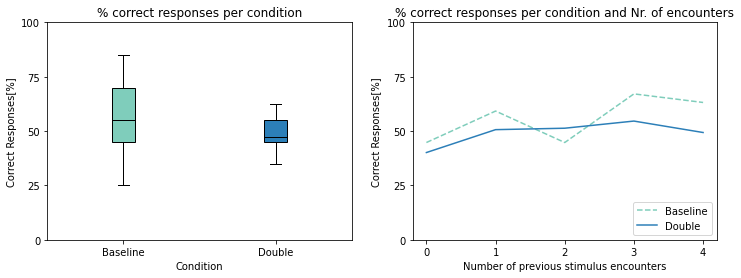

In [13]:
make_boxplot(0, ["Baseline", "Double"])

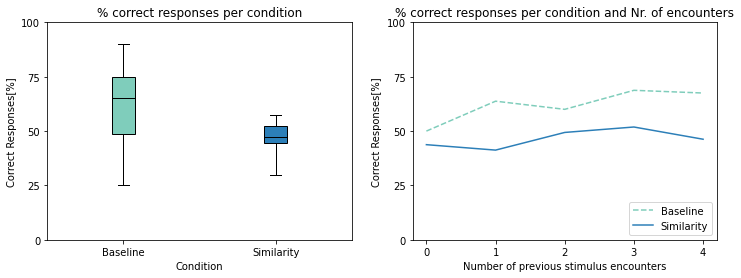

In [14]:
make_boxplot(1, ["Baseline", "Similarity"])

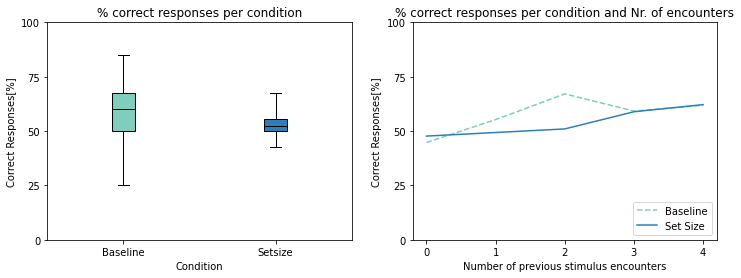

In [15]:
make_boxplot(2, ["Baseline", "Setsize"])

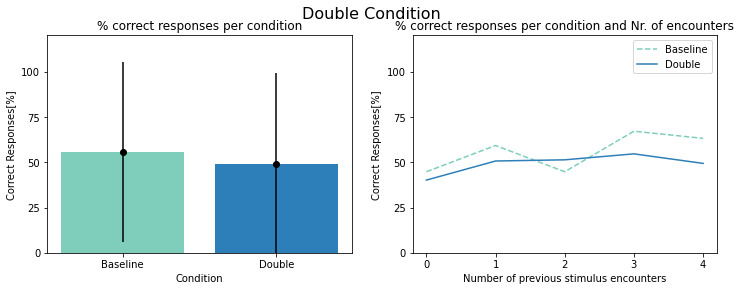

In [16]:
basic_plots(0, ["Baseline", "Double"])

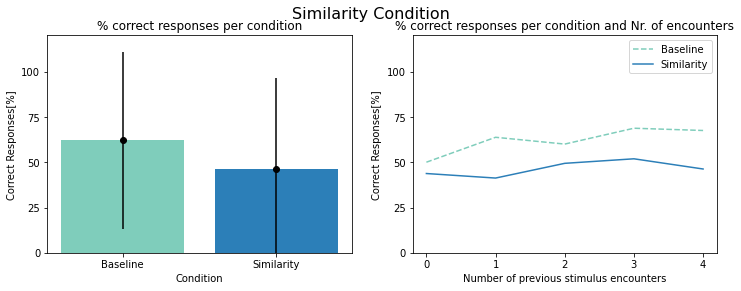

In [17]:
basic_plots(1, ["Baseline", "Similarity"])

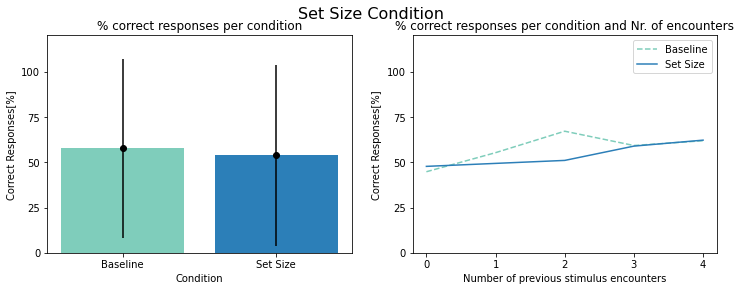

In [18]:
basic_plots(2, ["Baseline", "Setsize"])

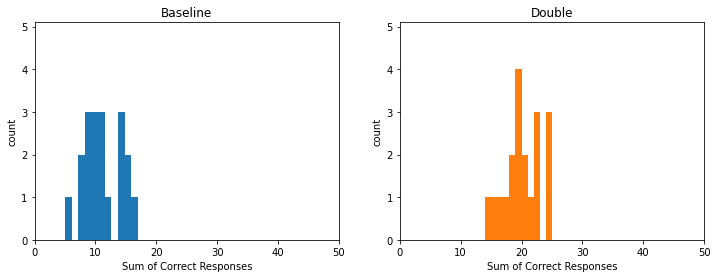

In [19]:
def basic_hist(condition, labels):
    plt.figure(figsize=(12,4))
    c0 = df[df["Condition"]==condition]
    plt.subplot(1,2,1)
    b = c0[c0["Block"]==labels[0]].groupby("Participant")["Correct_Response"].sum()
    x,y = np.histogram(b, bins = 11 ,density = False)
    plt.hist(b,bins = y)
    plt.ylim(0,5.1)
    plt.xlim(0,50)
    plt.title(labels[0])
    plt.xlabel("Sum of Correct Responses")
    plt.ylabel("count")
    plt.subplot(1,2,2)
    e = c0[c0["Block"]==labels[1]].groupby("Participant")["Correct_Response"].sum()
    x,y = np.histogram(e, bins = 11 ,density = False)
    plt.hist(e,bins = y, color = "tab:orange")
    plt.ylim(0,5.1)
    plt.xlim(0,50)
    plt.xlabel("Sum of Correct Responses")
    plt.ylabel("count")
    plt.title(labels[1])
    
basic_hist(0, ["Baseline", "Double"])

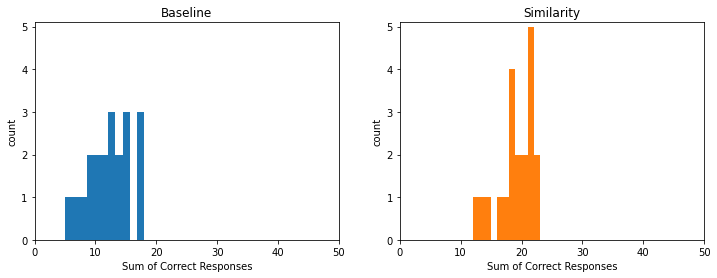

In [20]:
basic_hist(1, ["Baseline", "Similarity"])

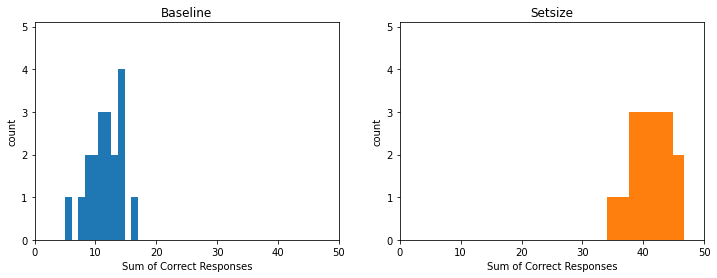

In [21]:
basic_hist(2, ["Baseline", "Setsize"])

## Results of Wilcoxon signed-rank test of performance in conditions

Differences in percentage of correct responses between the baseline and the experimental condition were tested for with the non-parametric Wilcoxon signed-rank test. For multiple testing, the p-value was adjusted according to the Bonferroni correction. 

No differences in performance between the Baseline and any of the experimental conditons were found. 

In [22]:
def get_wilcoxon_results(condition, labels):
    c0 = df[df["Condition"]==condition]
    x = c0[c0["Block"]== labels[0]].groupby("Participant")["Correct_Response"].sum() / c0[c0["Block"]== labels[0]].groupby("Participant")["Correct_Response"].size()
    print(scipy.stats.shapiro(x))
    y = c0[c0["Block"]== labels[1]].groupby("Participant")["Correct_Response"].sum() / c0[c0["Block"]== labels[1]].groupby("Participant")["Correct_Response"].size()
    print(scipy.stats.shapiro(y))
    print(scipy.stats.wilcoxon(x,y, mode = "approx"))
    print(scipy.stats.ttest_rel(x,y))

In [23]:
adjusted_p = 0.05/3
adjusted_p

0.016666666666666666

In [24]:
get_wilcoxon_results(0, ["Baseline", "Double"])

ShapiroResult(statistic=0.962913990020752, pvalue=0.6309513449668884)
ShapiroResult(statistic=0.9736763834953308, pvalue=0.846819281578064)
WilcoxonResult(statistic=48.5, pvalue=0.10697575954112411)
Ttest_relResult(statistic=1.7885046641679065, pvalue=0.09053917064161111)


In [25]:
get_wilcoxon_results(1, ["Baseline", "Similarity"])

ShapiroResult(statistic=0.9609391093254089, pvalue=0.5627778172492981)
ShapiroResult(statistic=0.9207990765571594, pvalue=0.10265793651342392)
WilcoxonResult(statistic=17.0, pvalue=0.002836069988224421)
Ttest_relResult(statistic=3.622404035351216, pvalue=0.001813582116706655)


In [26]:
get_wilcoxon_results(2, ["Baseline", "Setsize"]) 

ShapiroResult(statistic=0.9677153825759888, pvalue=0.7300198078155518)
ShapiroResult(statistic=0.9111344814300537, pvalue=0.07766492664813995)
WilcoxonResult(statistic=61.0, pvalue=0.1710220528762939)
Ttest_relResult(statistic=1.2514423708060987, pvalue=0.22679348448123984)


In [27]:
import math

In [28]:
t_df = df[df["Condition"]==1]
b_mean = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].mean()
b_var = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].var()
s_mean = t_df[t_df["Block"]=="Similarity"]["Correct_Response"].mean()
s_var = t_df[t_df["Block"]=="Similarity"]["Correct_Response"].var()
n1 = len(t_df[t_df["Block"]=="Baseline"])
n2 = len(t_df[t_df["Block"]=="Similarity"])
s = math.sqrt( ((n1 - 1) * b_var + (n2 - 1) * s_var)/(n1+n2-2)  )

In [29]:
# effect size 
t_df = df[df["Condition"]==1]
d = ((b_mean - s_mean) / s)
d

0.3132807371926704

In [30]:
t_df = df[df["Condition"]==0]
b_mean = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].mean()
b_var = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].var()
s_mean = t_df[t_df["Block"]=="Double"]["Correct_Response"].mean()
s_var = t_df[t_df["Block"]=="Double"]["Correct_Response"].var()
n1 = len(t_df[t_df["Block"]=="Baseline"])
n2 = len(t_df[t_df["Block"]=="Double"])
s = math.sqrt( ((n1 - 1) * b_var + (n2 - 1) * s_var)/(n1+n2-2)  )

t_df = df[df["Condition"]==0]
d = ((b_mean - s_mean) / s)
d

0.13176922441348188

In [31]:
t_df = df[df["Condition"]==2]
b_mean = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].mean()
b_var = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].var()
s_mean = t_df[t_df["Block"]=="Setsize"]["Correct_Response"].mean()
s_var = t_df[t_df["Block"]=="Setsize"]["Correct_Response"].var()
n1 = len(t_df[t_df["Block"]=="Baseline"])
n2 = len(t_df[t_df["Block"]=="Setsize"])
s = math.sqrt( ((n1 - 1) * b_var + (n2 - 1) * s_var)/(n1+n2-2)  )

t_df = df[df["Condition"]==2]
d = ((b_mean - s_mean) / s)
d

0.07663350534735917

# Analyse the effects of other factors than condition 
## Overview plot of performance per stimulus

The overview plot of performance per stimulus reveals an interesting pattern. 
The performance is better for the first half of stimuli across conditions (base0 - base2, dis0 - dis2, set0 - set4, vis0 - vis2). These are the pairs defined as "valid pairs" int he experiment. The order of presentation was randomized, so that this is not an effect of order. 

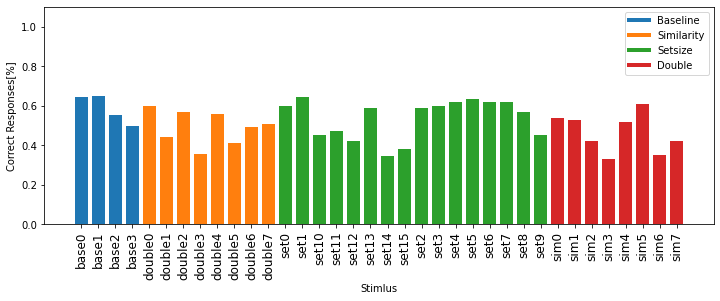

In [32]:
## Look at single stimuli
plt.figure(figsize=(12,4))
ss = df.groupby("Stimulus_ID")["Correct_Response"].sum() /df.groupby("Stimulus_ID")["Correct_Response"].size() 
col = ["tab:blue" for x in range(4)]
col.extend(["tab:orange" for x in range(8)])
col.extend(["tab:green" for x in range(16)])
col.extend(["tab:red" for x in range(8) ])
labels =["Baseline" for x in range(4)]
labels.extend(["Similarity" for x in range(8)])
labels.extend(["SetSize" for x in range(16)])
labels.extend(["Double" for x in range(8)])
plt.bar(ss.index, ss, color = col)
plt.xticks(rotation=90, fontsize = 12)
plt.ylabel("Correct Responses[%]")
plt.xlabel("Stimlus")
plt.ylim(0,1.1)

custom_lines = [plt.Line2D([0], [0], color="tab:blue", lw=4),
                plt.Line2D([0], [0], color="tab:orange", lw=4),
                plt.Line2D([0], [0], color="tab:green", lw=4),
               plt.Line2D([0], [0], color="tab:red", lw=4)]
plt.legend(custom_lines, ["Baseline", "Similarity", "Setsize", "Double"])
plt.show()

## Performance for valid and invalid pairs
Participants performed significantly better on stimuli pairs to be classifeid as valid than on those considered invalid. 

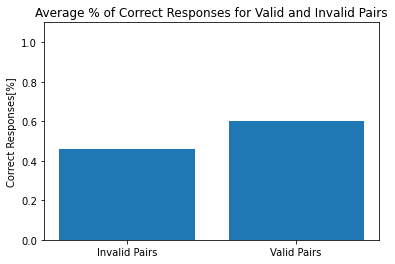

In [33]:
vi = df[df["Trial_Type"]=="categorize-html"]#.groupby("Associated")["Correct_Response"].sum() / df[df["Trial_Type"]=="categorize-html"].groupby("Associated")["Correct_Response"].size()


plt.bar(["Invalid Pairs","Valid Pairs"], [vi[vi["Associated"]== False]["Correct_Response"].mean(),vi[vi["Associated"]== True]["Correct_Response"].mean()])
#plt.errorbar(labels, x = vi[vi["Associated"]== False]["Correct_Response"].mean(),y = vi[vi["Associated"]== True]["Correct_Response"].mean(), yerr=c, fmt="o", color="k")
plt.ylim(0,1.1)
plt.ylabel("Correct Responses[%]")

plt.title("Average % of Correct Responses for Valid and Invalid Pairs")
plt.show()

In [34]:
x = vi[vi["Associated"]== True].groupby("Participant")["Correct_Response"].sum() / vi[vi["Associated"]== True].groupby("Participant")["Correct_Response"].size()
y = vi[vi["Associated"]== False].groupby("Participant")["Correct_Response"].sum() / vi[vi["Associated"]== False].groupby("Participant")["Correct_Response"].size()
print(scipy.stats.wilcoxon(x,y, mode = "approx"))

WilcoxonResult(statistic=131.5, pvalue=3.3048100350606344e-08)


In [35]:
t = df[df["Trial_Type"]=="categorize-html"]
TP = len(t[(t["Key"]==70) & (t["Associated"]==True)]) / len(t)
FP = len(t[(t["Key"]==70) & (t["Associated"]==False)]) / len(t)
TN = len(t[(t["Key"]==74) & (t["Associated"]==False)]) / len(t)
FN = len(t[(t["Key"]==74) & (t["Associated"]==True)]) / len(t)

In [36]:
[TP, FP, TN, FN]

[0.30047169811320756,
 0.2606132075471698,
 0.2285377358490566,
 0.1893867924528302]

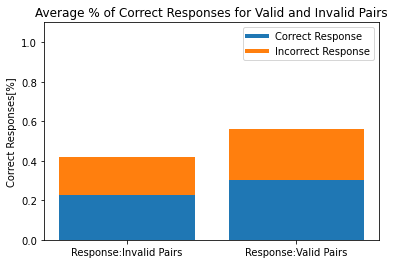

In [37]:
plt.bar(["Response:Invalid Pairs","Response:Valid Pairs"],[TN, TP])
plt.bar(["Response:Invalid Pairs","Response:Valid Pairs"],[FN, FP], bottom = [TN, TP])
#plt.errorbar(labels, x = vi[vi["Associated"]== False]["Correct_Response"].mean(),y = vi[vi["Associated"]== True]["Correct_Response"].mean(), yerr=c, fmt="o", color="k")
plt.ylim(0,1.1)
plt.ylabel("Correct Responses[%]")

plt.title("Average % of Correct Responses for Valid and Invalid Pairs")

custom_lines = [plt.Line2D([0], [0], color="tab:blue", lw=4),
                plt.Line2D([0], [0], color="tab:orange", lw=4)]
plt.legend(custom_lines, ["Correct Response", "Incorrect Response"])
plt.show()

# Did participants learn?

Contrast perfromance at the beginning and the end of learning.
## Performance of 2nd vs. 5th trial 
Significantly differs only for visual stimuli.

In [38]:
# first / last per condition 
def test_learning(condition):
    fl = df[df["Block"]==condition]
    if condition == "all":
        fl = df[df["Trial_Type"]=="categorize-html"]
    
    print(len(fl))
    first = fl[fl["Nr_Pres"]== 1].groupby("Participant")["Correct_Response"].sum() / fl[fl["Nr_Pres"]== 0].groupby("Participant")["Correct_Response"].size()
    last = fl[fl["Nr_Pres"]== 4].groupby("Participant")["Correct_Response"].sum() / fl[fl["Nr_Pres"]== 4].groupby("Participant")["Correct_Response"].size()
    print(scipy.stats.wilcoxon(first,last, mode = "approx"))

In [39]:
adjusted_p = 0.05/4
adjusted_p

0.0125

In [40]:
test_learning("Baseline")

1160
WilcoxonResult(statistic=334.0, pvalue=0.19534178553667392)


In [41]:
test_learning("Double")

760
WilcoxonResult(statistic=71.0, pvalue=0.7894499881427257)


In [42]:
test_learning("Setsize")

1520
WilcoxonResult(statistic=14.0, pvalue=0.0017135136143248094)


In [43]:
test_learning("Similarity")

800
WilcoxonResult(statistic=47.0, pvalue=0.4566479247341352)


In [44]:
m_df = pd.DataFrame()
correct = df[df["Trial_Type"]=="categorize-html"].groupby(["Participant"])["Correct_Response"].sum() / df.groupby("Participant")["Correct_Response"].size()
#_df["trial_1"] = df[df["Trial_Type"]=="categorize-html"].groupby(["Participant"])["Correct_Response"]
above_correct = correct[correct > correct.median()]
below_correct = correct[correct <= correct.median()]

below_correct.index

Index(['599a9be505a0e30001f2001c', '59b60753773f410001487a06',
       '5a5a2744e0cf3d000126713e', '5d543e2c68ec7c0001682a58',
       '5ea82e55de405c048862dd76', '610139a0e4c7759d4cdbe03e',
       '6104197f342d329e8611416f', '6105a5c5ff0d8705c35b839d',
       '6107c741127c28b989bc148d', '610b204f87cd36fca8dab7a6',
       '6110a887726c80eb7fbc1dc5', '6110ac99ccc46b155bf7637c',
       '6110ef5899013fcac5fe5f94', '6111265fa6f2e9d318c251be',
       '6112296416c0624393c804e9', '61128b3773eee37c8ee87615',
       '61128d38f512d6800205d192', '611377fd09174366ceb0193b',
       '6113d17fcf4f0cdf9c44b0c1', '61143bd22a1649da3b52ae32',
       '6114d6b9cce7a0ecf3ab79c3', '6114dcb0cbc8abe57ba9d6e1',
       '61156d0f0f1d497c600b541e', '6115a15c77fe590a86f5c72b',
       '6115a8ac37007e3abfd77375', '61164214506911d2038591f0',
       '6116780c007c18e89acd7281', '61168a300801c7280f4a4b6e',
       '6117bf801d55e333202217ec', '6119bdc932d9ebe82ea581e1',
       '611a160b6ca490d37eb34011'],
      dtype='object

## Compare high vs low performing participants

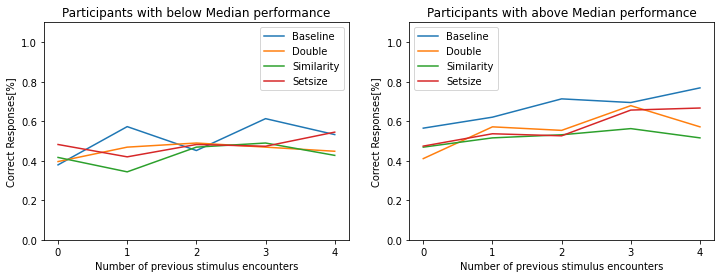

In [45]:
mask = df["Participant"].isin(below_correct.index)
b = df[mask]
mask = df["Participant"].isin(above_correct.index)
a = df[mask]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
linedata = b.groupby(["Block","Nr_Pres"])["Correct_Response"].sum() / b.groupby(["Block", "Nr_Pres"])["Correct_Response"].size()
plt.title("Participants with below Median performance")
plt.plot([x for x in range(0,5)],linedata["Baseline"][:], label = "Baseline")
plt.plot([x for x in range(0,5)],linedata["Double"][:], label = "Double")
plt.plot([x for x in range(0,5)],linedata["Similarity"][:], label = "Similarity")
plt.plot([x for x in range(0,5)],linedata["Setsize"][:], label = "Setsize")
plt.legend()
plt.ylim(0,1.1)
plt.ylabel("Correct Responses[%]")
plt.xticks([0,1,2,3,4])        
plt.xlabel("Number of previous stimulus encounters")

plt.subplot(1,2,2)
linedata = a.groupby(["Block","Nr_Pres"])["Correct_Response"].sum() / a.groupby(["Block", "Nr_Pres"])["Correct_Response"].size()
plt.title("Participants with above Median performance")
plt.plot([x for x in range(0,5)],linedata["Baseline"][:], label = "Baseline")
plt.plot([x for x in range(0,5)],linedata["Double"][:], label = "Double")
plt.plot([x for x in range(0,5)],linedata["Similarity"][:], label = "Similarity")
plt.plot([x for x in range(0,5)],linedata["Setsize"][:], label = "Setsize")
plt.legend()
plt.ylim(0,1.1)
plt.ylabel("Correct Responses[%]")
plt.xticks([0,1,2,3,4])        
plt.xlabel("Number of previous stimulus encounters")
#plt.suptitle(labels[1]+" Condition", fontsize = 16)
plt.show()

plt.show()

## Learning Curves for each Particpant

6116780c007c18e89acd7281


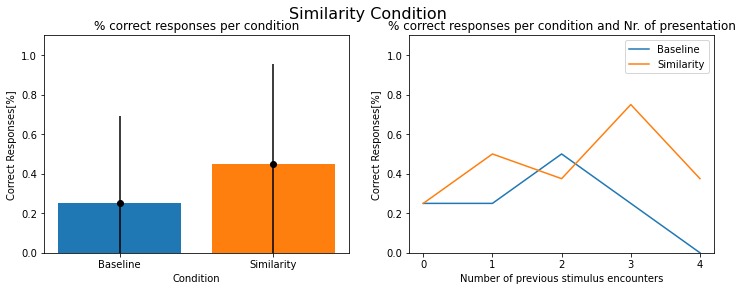

611a160b6ca490d37eb34011


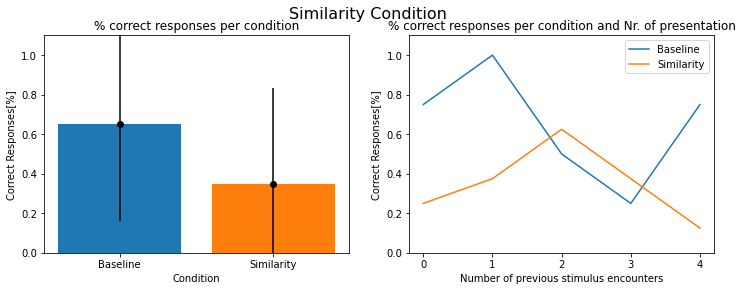

611968f5cef3c1cee6e49d14


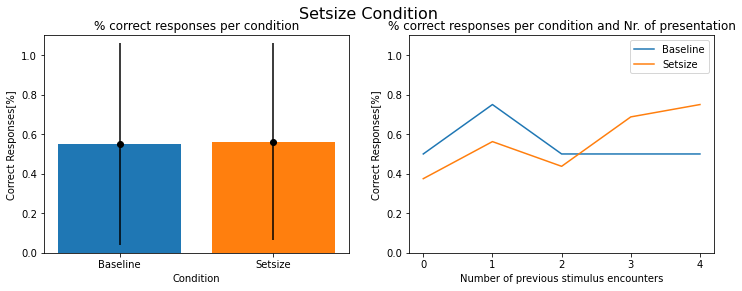

5b715800b31d480001eda165


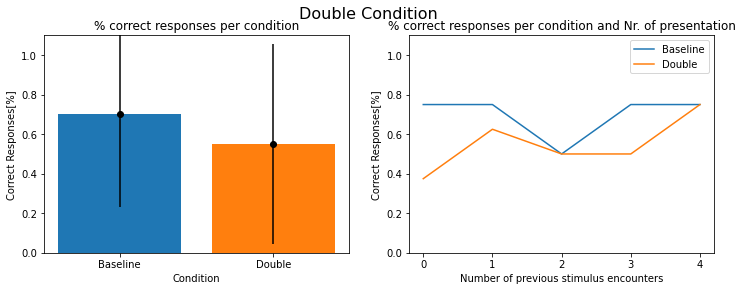

599a9be505a0e30001f2001c


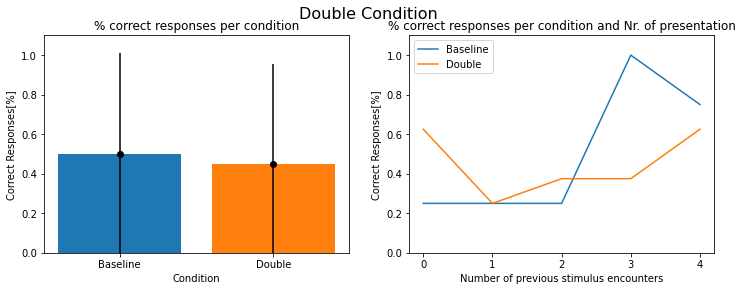

6105a5c5ff0d8705c35b839d


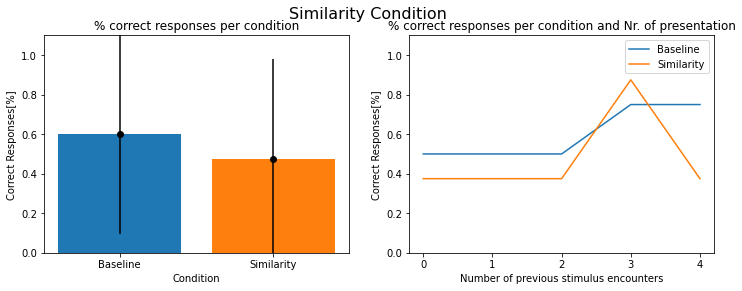

61130aa6625c523beb237643


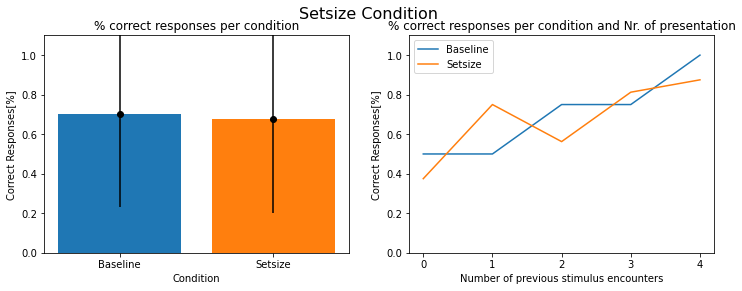

60fe94a3972636ed70cf5e8f


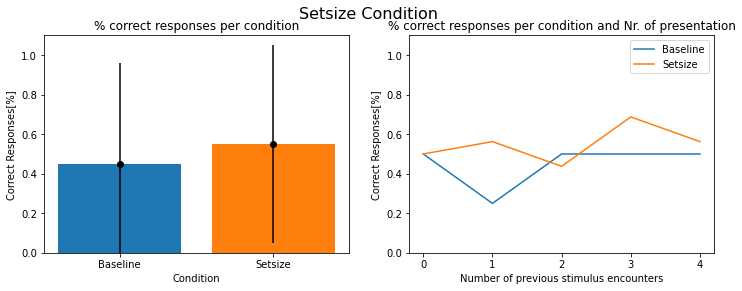

61114b84f3449e85a4a9317e


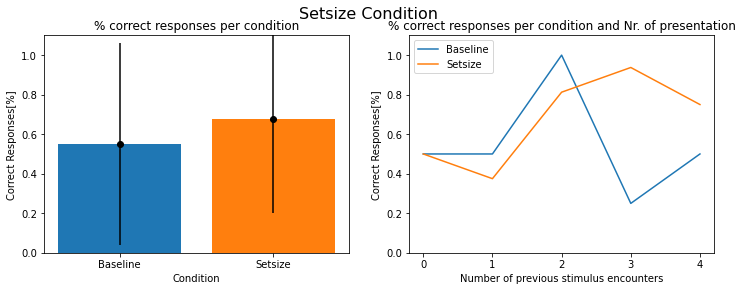

6119bdc932d9ebe82ea581e1


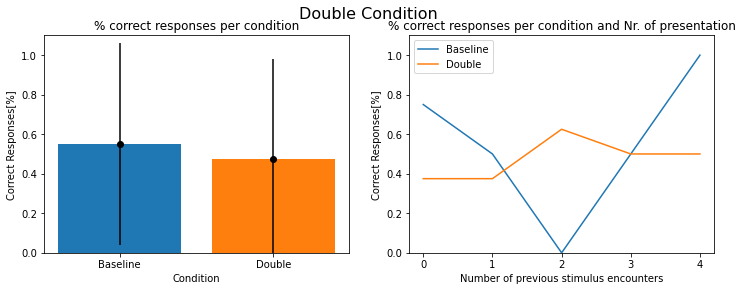

6117bf801d55e333202217ec


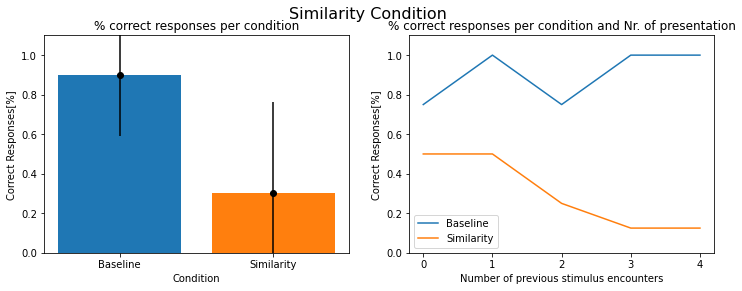

6115a15c77fe590a86f5c72b


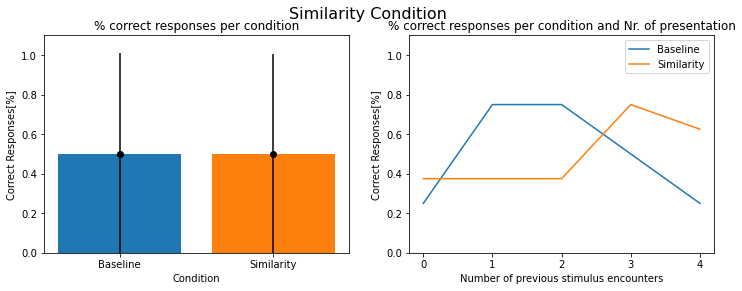

611377fd09174366ceb0193b


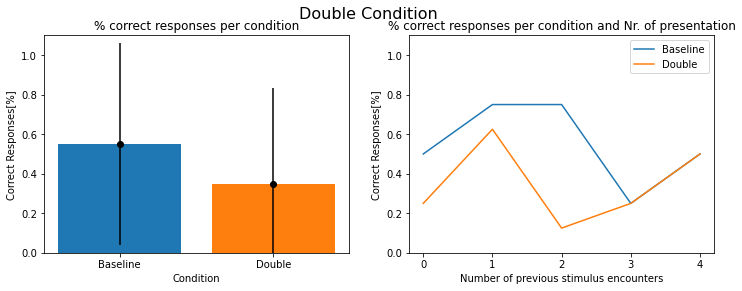

610dc6e38dfaae3e49c68b9b


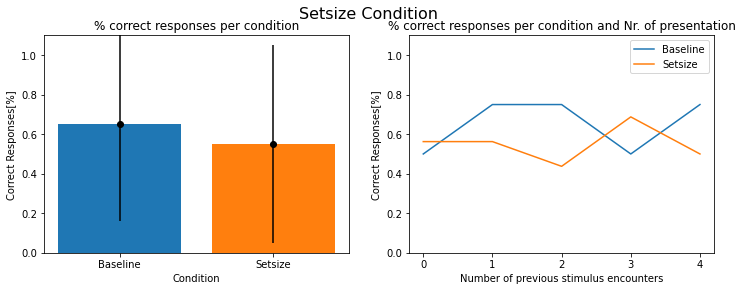

61179efb56a2a878c5c4d85e


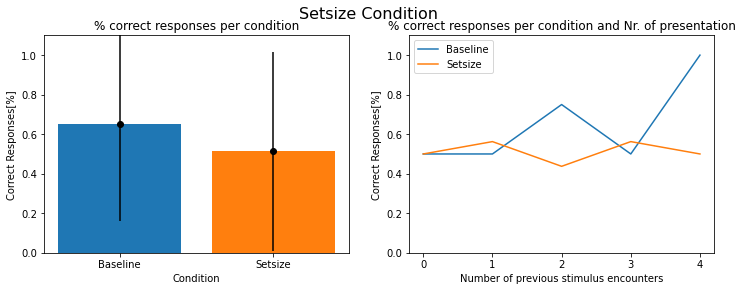

5a5a2744e0cf3d000126713e


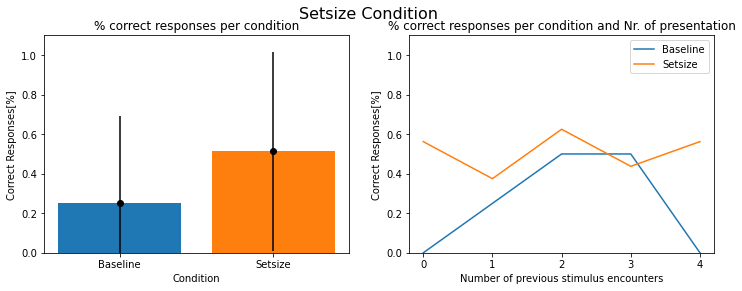

6110a887726c80eb7fbc1dc5


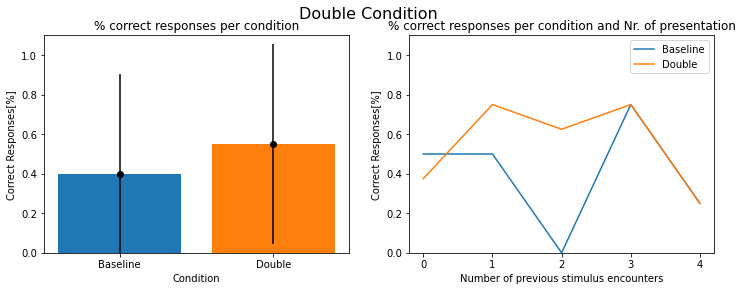

5ea82e55de405c048862dd76


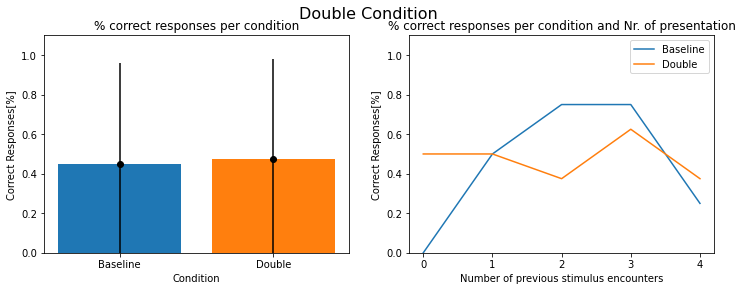

5d543e2c68ec7c0001682a58


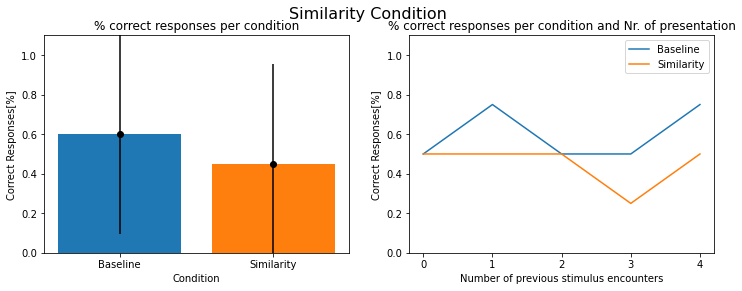

6104197f342d329e8611416f


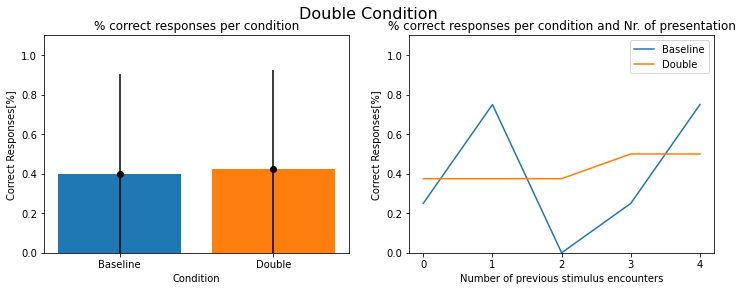

6110ac99ccc46b155bf7637c


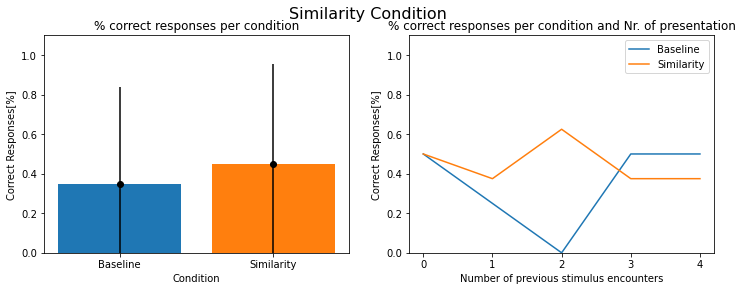

611279d40113f7ee99359ba4


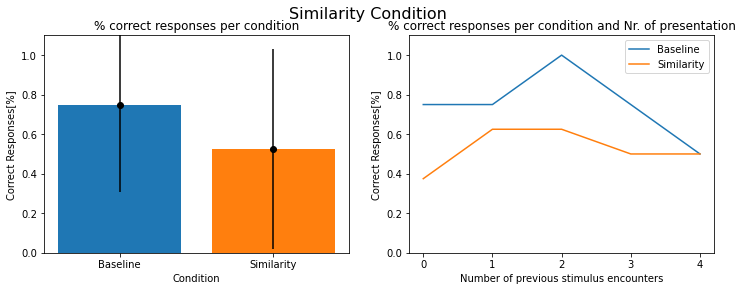

6109acce713153985970e7cd


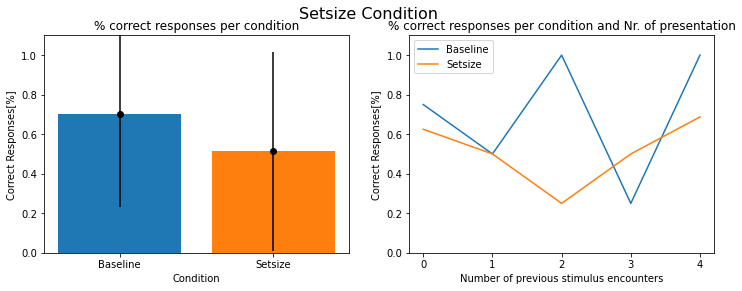

61190eb767f0ce824e76dde0


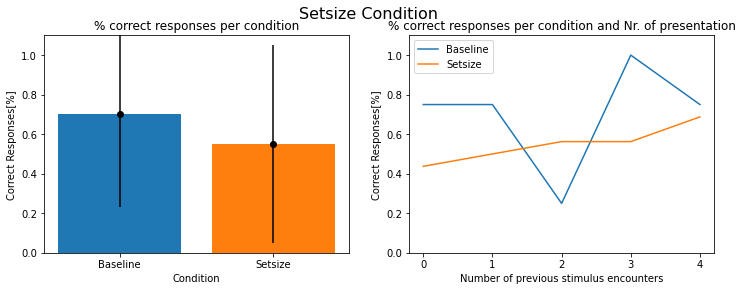

610aa4d6db955f177048d16c


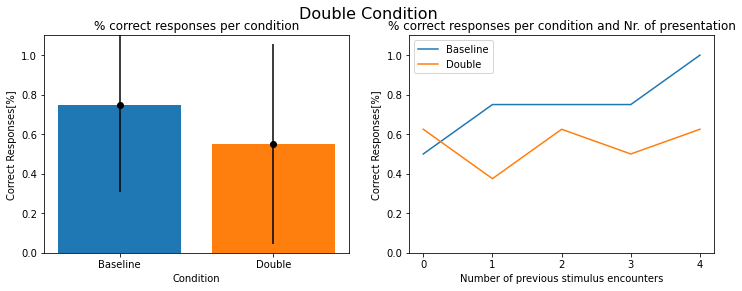

61171a54a45f9ffc236675db


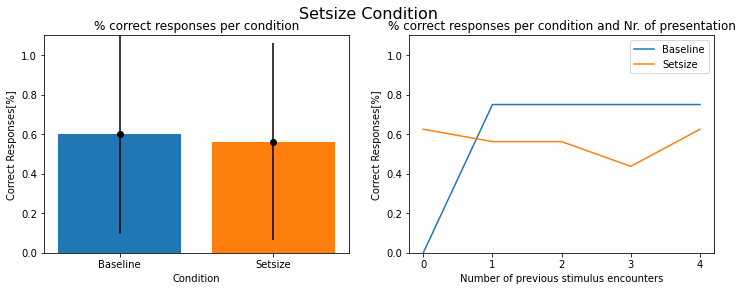

6113d17fcf4f0cdf9c44b0c1


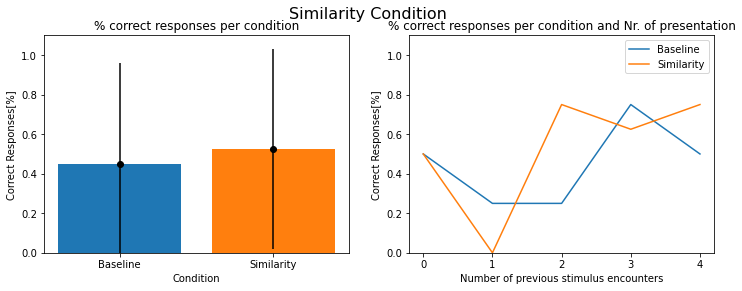

610139a0e4c7759d4cdbe03e


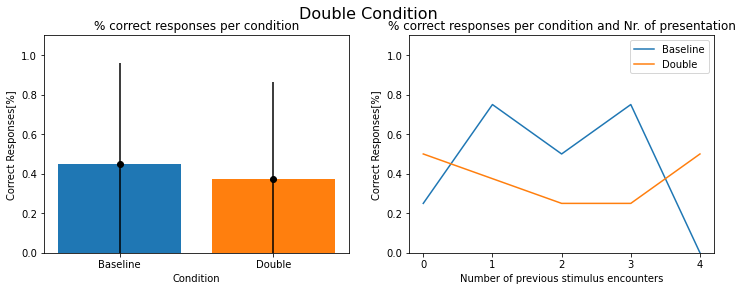

6111265fa6f2e9d318c251be


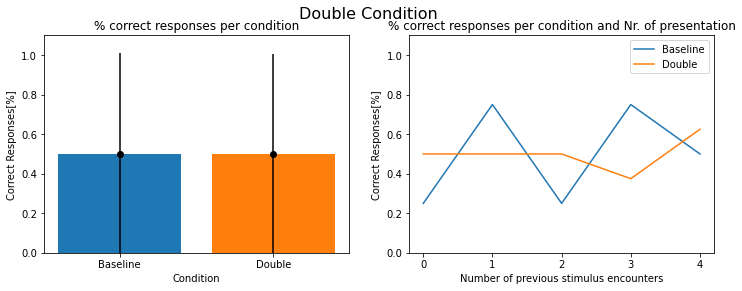

60fd99beb9ea0e0b580842ba


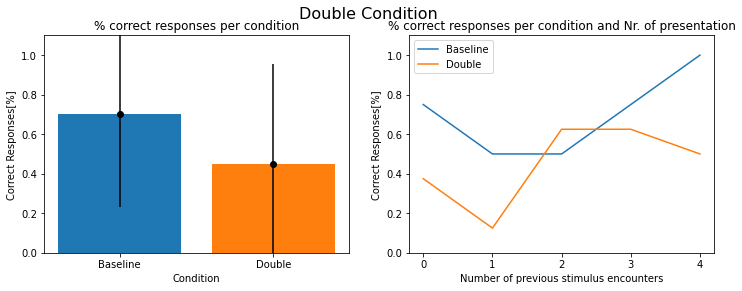

61164214506911d2038591f0


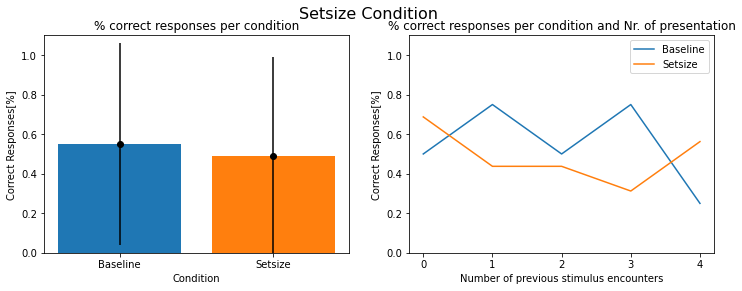

6107c741127c28b989bc148d


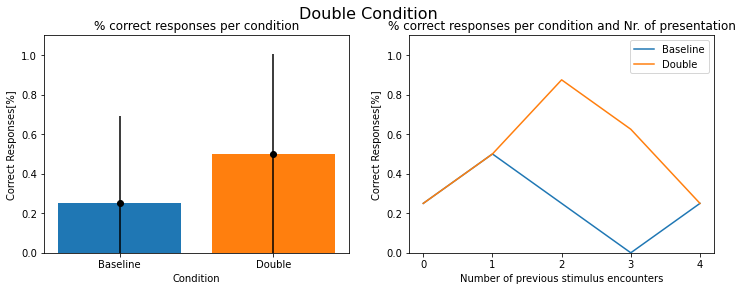

611a1b05104423c73d386b55


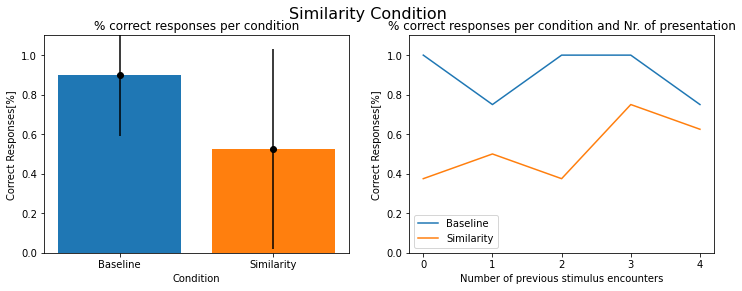

6110d9089d499cc6e5606200


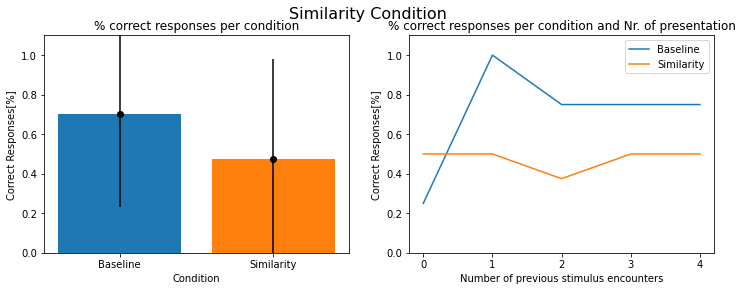

6116d9f7527268b298bb3b2a


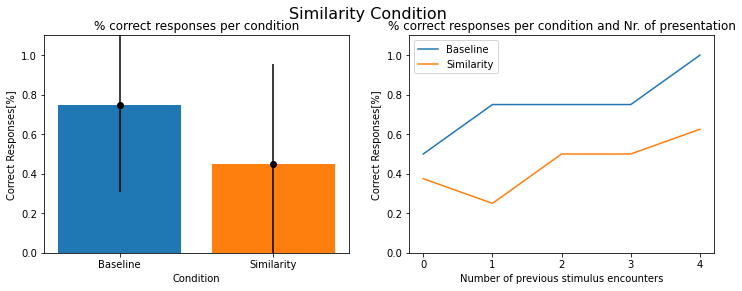

59b60753773f410001487a06


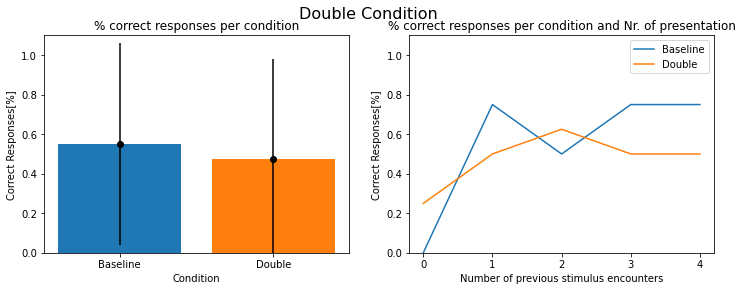

6112296416c0624393c804e9


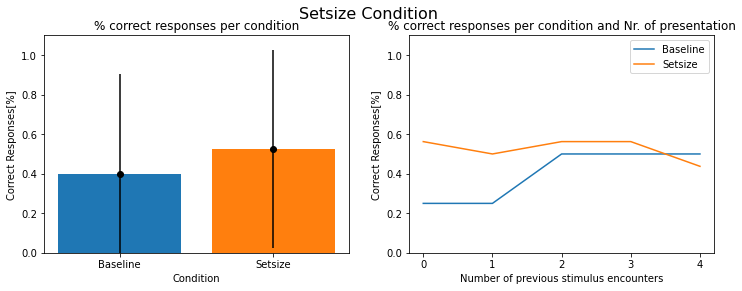

61128d38f512d6800205d192


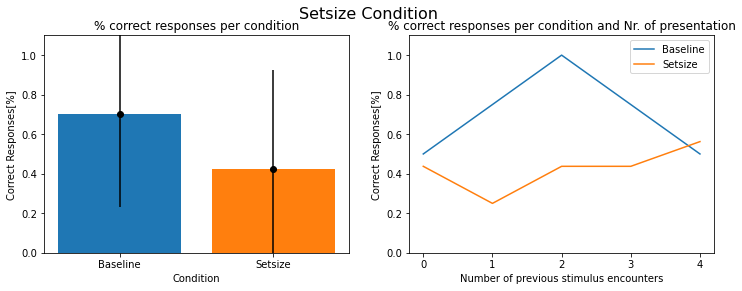

6110ef5899013fcac5fe5f94


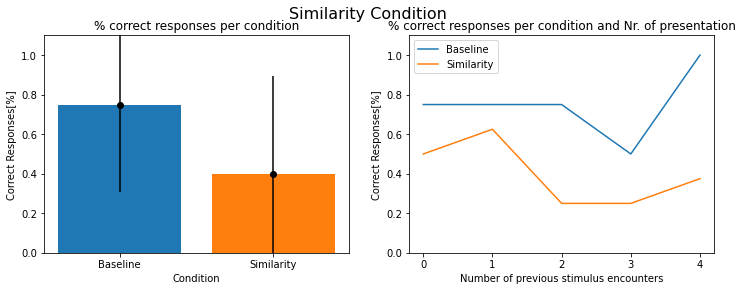

61128b3773eee37c8ee87615


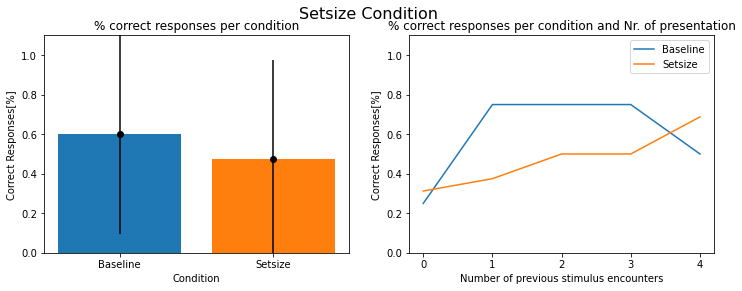

61156d0f0f1d497c600b541e


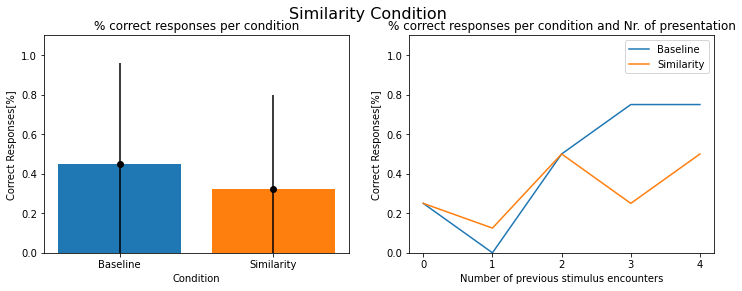

61143bd22a1649da3b52ae32


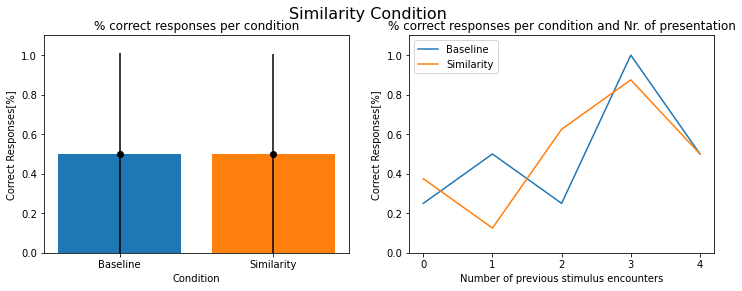

610b204f87cd36fca8dab7a6


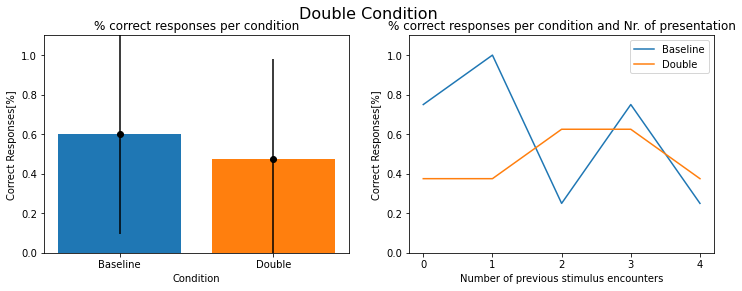

5c9102879b3d790017dbad56


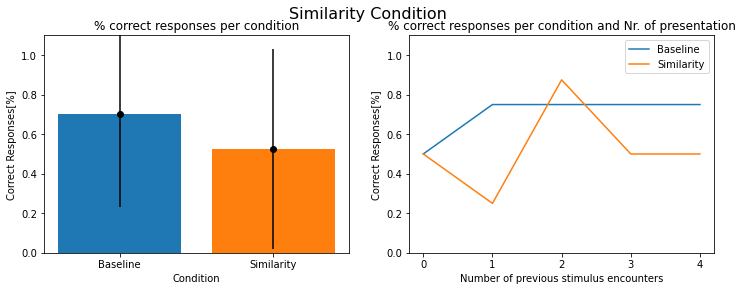

6117673423c5fe4b615f33ca


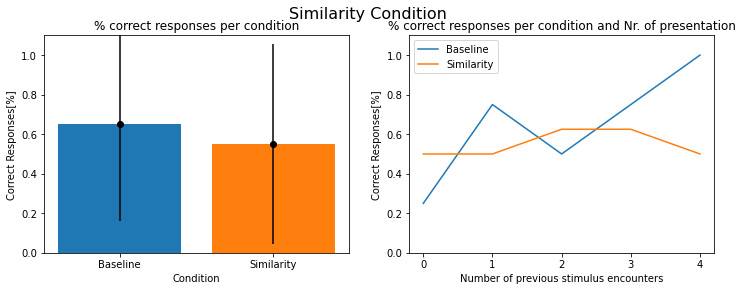

6115a8ac37007e3abfd77375


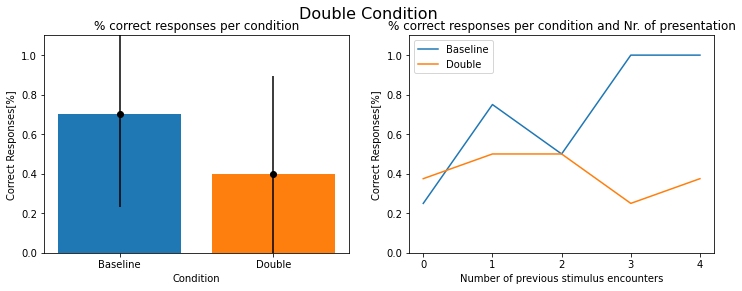

6105e2481bfad538d5444e30


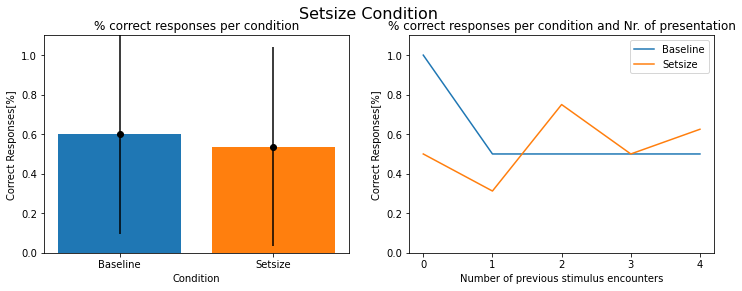

61028398a2621150a1fed341


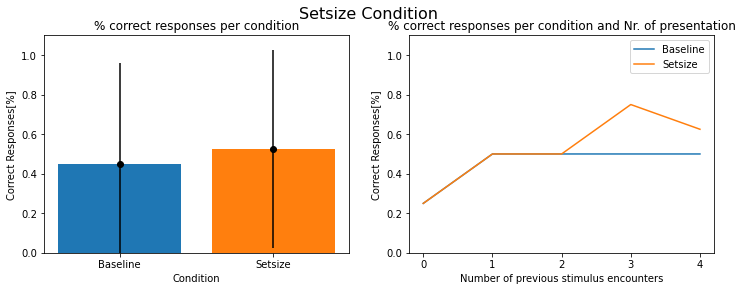

6112624ef121489f9b4ee7c2


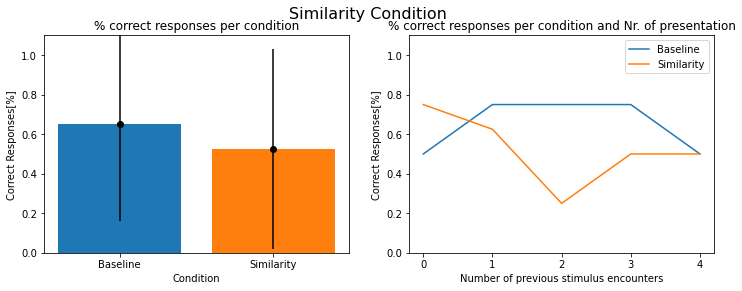

6115960976d56e7c9ef6daaa


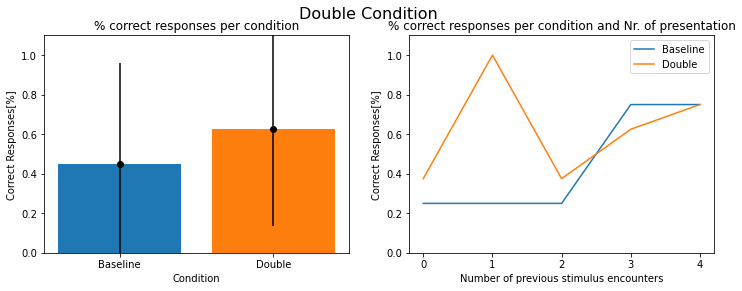

610460e5c821be00941ffc95


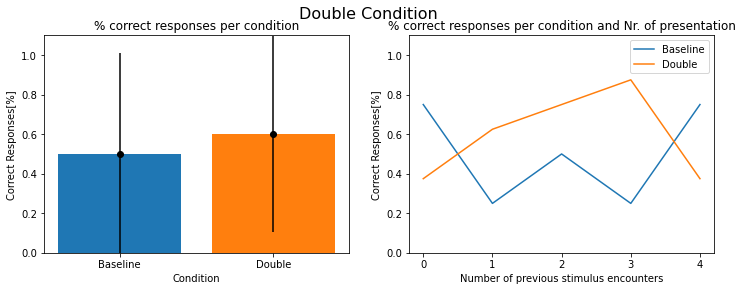

61168a300801c7280f4a4b6e


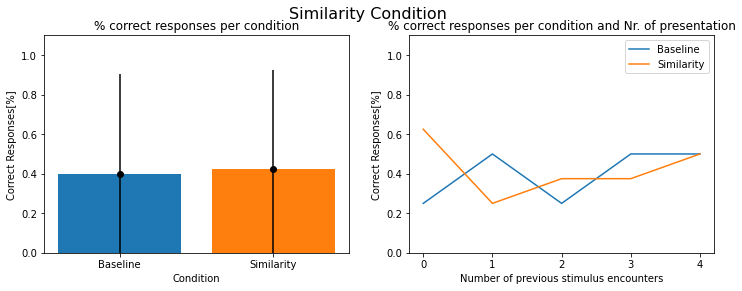

6114d6b9cce7a0ecf3ab79c3


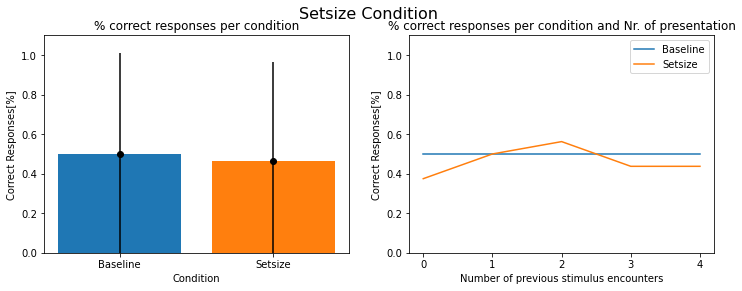

6114dcb0cbc8abe57ba9d6e1


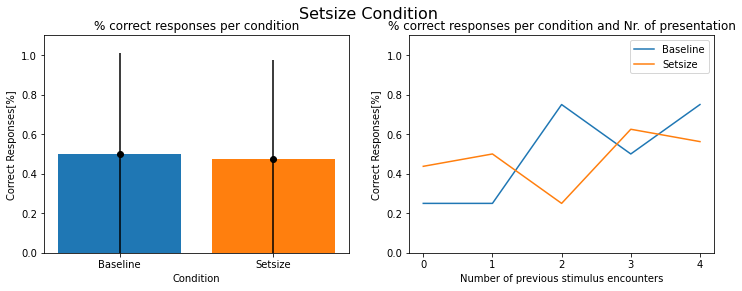

611931217df894fdb8a02ec0


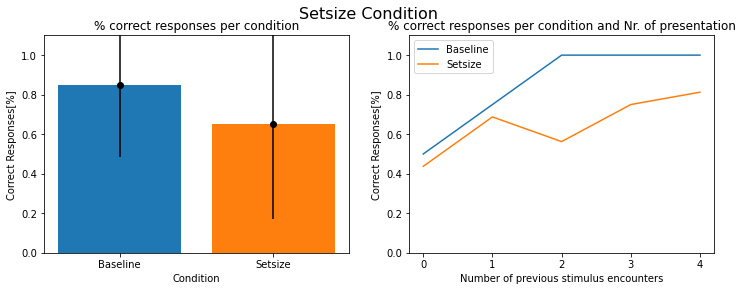

6111681d03e55af92ab520e4


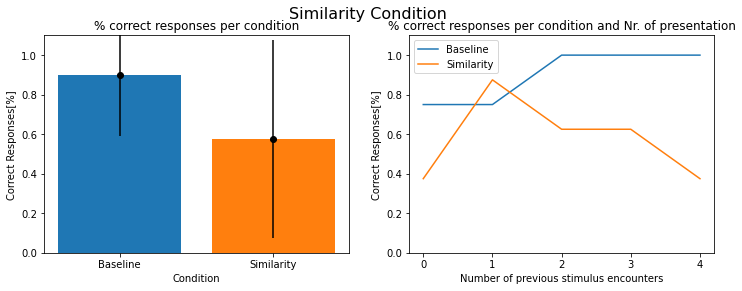

61140ecd6c72bb8ce54d0ac8


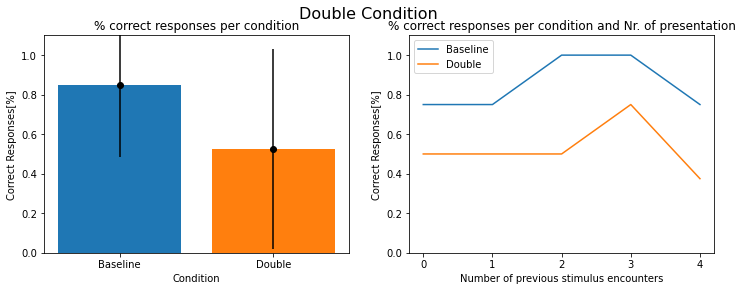

61123f3ee9bf5d9dd344a796


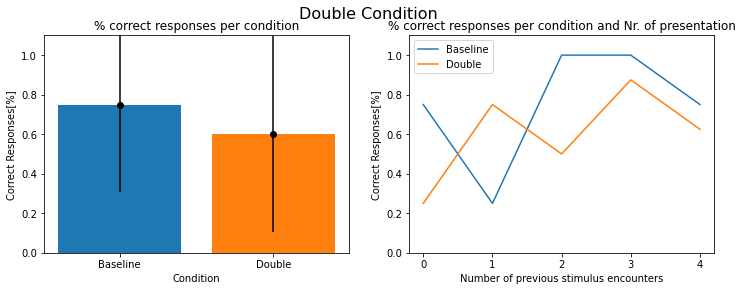

In [46]:
def basic_plots_pp():
    plt.figure(figsize=(12,4))
    condition = list(df_p["Condition"])[0]
    labels = [["Baseline", "Double"],["Baseline", "Similarity"],["Baseline", "Setsize"]][condition]
    c0 = df_p
    plt.subplot(1,2,1)
    plt.title("% correct responses per condition")
    plt.bar(labels, [c0[c0["Block"]==labels[0]]["Correct_Response"].mean(),c0[c0["Block"]==labels[1]]["Correct_Response"].mean()], color=['tab:blue', 'tab:orange'])
    plt.errorbar(labels, [c0[c0["Block"]==labels[0]]["Correct_Response"].mean(),c0[c0["Block"]==labels[1]]["Correct_Response"].mean()], yerr=[c0[c0["Block"]==labels[0]]["Correct_Response"].std(),c0[c0["Block"]==labels[1]]["Correct_Response"].std()], fmt="o", color="k")
    plt.ylim(0,1.1)
    plt.ylabel("Correct Responses[%]")
    plt.xlabel("Condition")
    plt.subplot(1,2,2)
    linedata = c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].sum() / c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].size()
    plt.title("% correct responses per condition and Nr. of presentation")
    plt.plot([x for x in range(0,5)],linedata[labels[0]][:], label = labels[0])
    plt.plot([x for x in range(0,5)],linedata[labels[1]][:], label = labels[1])
    plt.legend()
    plt.ylim(0,1.1)
    plt.ylabel("Correct Responses[%]")
    plt.xticks([0,1,2,3,4])        
    plt.xlabel("Number of previous stimulus encounters")
    plt.suptitle(labels[1]+" Condition", fontsize = 16)
    plt.show()

for participant in df["Participant"].unique():
    print(participant)
    df_p = df[df["Participant"]==participant]
    basic_plots_pp()

In [47]:
#TODO get percentage of people failing to learn 
df[df["Participant"]=="debugeAYIh"]

,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT,Nr_Pres


In [48]:
df["RT"].mean()

1480.719585642014

In [49]:
mask = df["Participant"].isin(below_correct.index)
b = df[mask]
mask = df["Participant"].isin(above_correct.index)
a = df[mask]

b["RT"].mean()

1513.0354575946335

In [50]:
#x,y = np.histogram(df[df["Trial_Type"]=="categorize-html"]["RT"], bins = 50 ,density = False)
#plt.hist(df[df["Trial_Type"]=="categorize-html"]["RT"],bins = y)

In [51]:
df[df["Trial_Type"]=="categorize-html"]["RT"].min()

78.0

# Bonus Payments

In [52]:
bonus = df.groupby("Participant")["Correct_Response"].sum()/ df.groupby("Participant")["Correct_Response"].size()
min_b = bonus.min()
min_b
max_b = bonus.max()
max_b

0.6635514018691588

In [53]:
def ra(x):
    if x > 2:
        return 2
    elif x <= -2:
        return -2
    else:
        return x
#bonus_pay = bonus.apply(lambda x: (x - min_b)/(max_b - min_b) * (0.5 - 0.0) + 0)
bonus_pay = bonus.apply(lambda x: (x - bonus.mean())/(bonus.std()))
bonus_pay = bonus_pay.apply(lambda x: ra(x))
bonus_pay = bonus_pay.apply(lambda x: x / 10)
bonus_pay = bonus_pay.apply(lambda x: x + 0.25)
bonus_pay = bonus_pay.apply(lambda x: round(x, 2))
bonus_pay.to_csv("bonuses.csv")



In [54]:
bonus_pay_f = bonus_pay.apply(lambda x: (x - min_b)/(max_b - min_b) * (0.5 - 0.0) + 0)
bonus_pay_f

Participant
599a9be505a0e30001f2001c   -0.340943
59b60753773f410001487a06   -0.226318
5a5a2744e0cf3d000126713e   -0.291818
5b715800b31d480001eda165   -0.029817
5c9102879b3d790017dbad56   -0.095317
5d543e2c68ec7c0001682a58   -0.259068
5ea82e55de405c048862dd76   -0.291818
60fd99beb9ea0e0b580842ba   -0.160818
60fe94a3972636ed70cf5e8f   -0.144443
610139a0e4c7759d4cdbe03e   -0.471944
61028398a2621150a1fed341   -0.193568
6104197f342d329e8611416f   -0.406444
610460e5c821be00941ffc95   -0.095317
6105a5c5ff0d8705c35b839d   -0.193568
6105e2481bfad538d5444e30   -0.111693
6107c741127c28b989bc148d   -0.406444
6109acce713153985970e7cd   -0.111693
610aa4d6db955f177048d16c    0.002933
610b204f87cd36fca8dab7a6   -0.193568
610dc6e38dfaae3e49c68b9b   -0.062567
6110a887726c80eb7fbc1dc5   -0.226318
6110ac99ccc46b155bf7637c   -0.406444
6110d9089d499cc6e5606200   -0.128068
6110ef5899013fcac5fe5f94   -0.193568
6111265fa6f2e9d318c251be   -0.226318
61114b84f3449e85a4a9317e    0.101183
6111681d03e55af92ab520e4  

In [55]:
bonus_pay_f.mean()

-0.17747511066303304

In [56]:
len(bonus_pay)

58

In [57]:
bonus_pay["611a160b6ca490d37eb34011"]

0.15

# P(Success|List)

In [58]:
df[(df["Block"]=="Baseline")]["Correct_Response"].mean()

0.5853448275862069

In [59]:
df[(df["Block"]=="Similarity")]["Correct_Response"].mean()

0.465

In [60]:
df

,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT,Nr_Pres
0,6116780c007c18e89acd7281,1,0,html-keyboard-response,2021-08-16 09:16:44.695,13.0,2348,None,None,None,None,NaN,0
1,6116780c007c18e89acd7281,1,1,html-keyboard-response,2021-08-16 09:17:39.845,70.0,57499,None,None,None,None,NaN,1
2,6116780c007c18e89acd7281,1,2,html-keyboard-response,2021-08-16 09:17:52.273,70.0,69927,None,None,None,None,NaN,2
3,6116780c007c18e89acd7281,1,3,categorize-html,2021-08-16 09:17:56.196,74.0,73850,False,Baseline,True,base1,1915.0,0
4,6116780c007c18e89acd7281,1,4,categorize-html,2021-08-16 09:17:59.558,74.0,77212,False,Baseline,True,base0,1055.0,0
5,6116780c007c18e89acd7281,1,5,categorize-html,2021-08-16 09:18:02.221,74.0,79875,True,Baseline,False,base3,358.0,0
6,6116780c007c18e89acd7281,1,6,categorize-html,2021-08-16 09:18:04.887,70.0,82540,False,Baseline,False,base2,360.0,0
7,6116780c007c18e89acd7281,1,7,categorize-html,2021-08-16 09:18:08.419,70.0,86072,False,Baseline,False,base3,1226.0,1
8,6116780c007c18e89acd7281,1,8,categorize-html,2021-08-16 09:18:12.403,70.0,90057,True,Baseline,True,base0,1672.0,1
9,6116780c007c18e89acd7281,1,9,categorize-html,2021-08-16 09:18:16.510,74.0,94164,False,Baseline,True,base1,1800.0,1
